In [4]:
# Extract Zip file Cat Vs Dog
import zipfile
with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

with zipfile.ZipFile('data/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/catVSdog/test')

with zipfile.ZipFile('data/train.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/catVSdog/train')

In [1]:
import os
from os import makedirs
from os import listdir

from shutil import copyfile
from shutil import rmtree

from random import random

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dataset_home = 'data/catVSdog/'

In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Please install GPU version of TF


In [6]:
# create directories
subdirs = ['train/train_temp', 'train/test']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = os.path.join(dataset_home, subdir, labldir)
		makedirs(newdir, exist_ok=True)

# Move files
def moveFile(src_directory):
    val_ratio = 0.25
    src_directory = os.path.join(dataset_home, src_directory)
    for file in listdir(src_directory):
        src = os.path.join(src_directory, file)
        dst_dir = 'train/train_temp/'
        if random() < val_ratio:
            dst_dir = 'train/test/'
        if file.startswith('cat'):
            dst = os.path.join(dataset_home, dst_dir, 'cats/',file)
            copyfile(src, dst)
        elif file.startswith('dog'):
            dst = os.path.join(dataset_home, dst_dir, 'dogs/', file)
            copyfile(src, dst)

train_src_directory = 'train/train/'
moveFile(train_src_directory)

# Rename
src = os.path.join(dataset_home, train_src_directory)
try:
    rmtree(src)
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))

os.rename(os.path.join(dataset_home,'train/train_temp/'),
          os.path.join(dataset_home,'train/train/'))

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_home, 'train/train'),
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        os.path.join(dataset_home, 'train/test'),
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 18702 images belonging to 2 classes.
Found 6298 images belonging to 2 classes.


In [5]:
class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1   = tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3))
    self.mp1     = tf.keras.layers.MaxPool2D(2,2)

    self.conv2   = tf.keras.layers.Conv2D(32, (3,3), activation='relu')
    self.mp2     = tf.keras.layers.MaxPooling2D(2,2)

    self.conv3   = tf.keras.layers.Conv2D(64, (3,3), activation='relu')
    self.mp3     = tf.keras.layers.MaxPooling2D(2,2)

    self.flatten = tf.keras.layers.Flatten()
    self.fc      = tf.keras.layers.Dense(512, activation='relu')
    self.out  = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.mp1(x)

    x = self.conv2(x)
    x = self.mp2(x)

    x = self.conv3(inputs)
    x = self.mp3(x)

    x = self.flatten(x)
    x = self.fc(x)
    output = self.out(x)
    return output

model = MyModel()
model.compile(
              optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

callbacks = [
             tf.keras.callbacks.ModelCheckpoint(
                    'catVSDogCP.',
                    monitor='val_accuracy',
                    verbose=0,
                    save_best_only=True)
            ]

history = model.fit(
                     train_generator,
                     epochs = 10,
                     callbacks = callbacks,
                     validation_data = validation_generator,
                     verbose = 1
                   )

/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/anaconda/envs

Train for 584 steps, validate for 198 steps
Epoch 1/10
584/584 [==============================] - 161s 275ms/step - loss: 1.1874 - accuracy: 0.6286 - val_loss: 0.5748 - val_accuracy: 0.7127

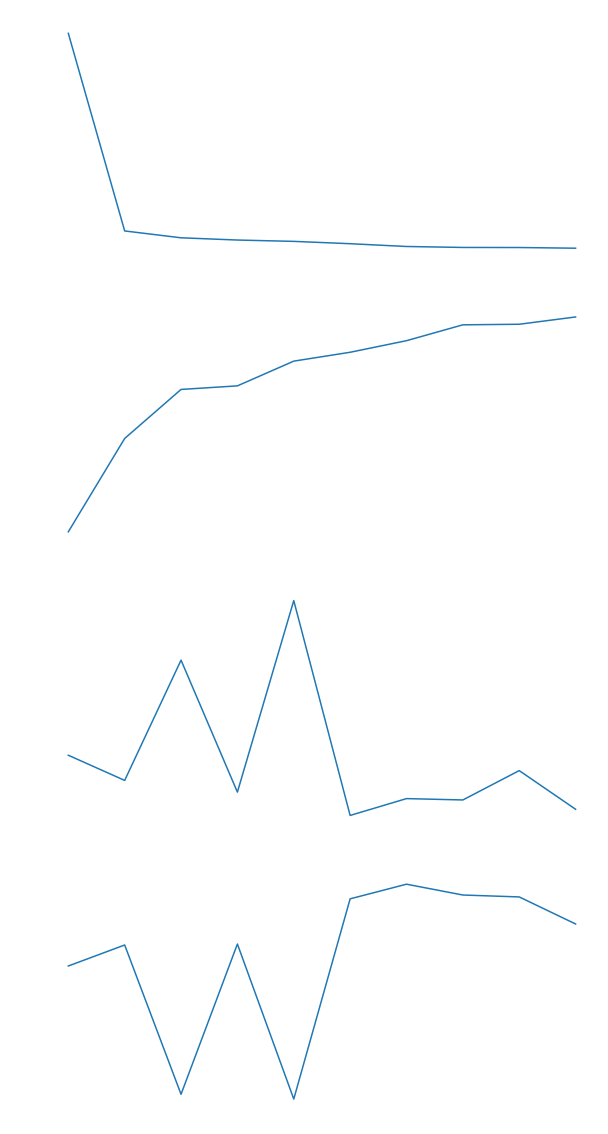

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,20))
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "axes.titlecolor": "w"}
plt.rcParams.update(params)

plt.subplot(4,1,1)
plt.plot(history.history['loss'])
plt.title('train_loss');

plt.subplot(4,1,2)
plt.plot(history.history['accuracy'])
plt.title('train_accuracy');

plt.subplot(4,1,3)
plt.plot(history.history['val_loss'])
plt.title('val_loss');

plt.subplot(4,1,4)
plt.plot(history.history['val_accuracy'])
plt.title('val_accuracy');


In [6]:
model.load_weights('checkpoints\dogs-vs-cats\catVSDogCP.')
loss, acc = model.evaluate(train_generator, verbose=2)
print("model, accuracy: {:5.2f}%".format(100*acc))

C:\Users\bank\Anaconda3\envs\TensorflowCert\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\bank\Anaconda3\envs\TensorflowCert\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


585/585 - 795s - loss: 0.5440 - accuracy: 0.7320
model, accuracy: 73.20%
